In [239]:
import numpy as np
import pandas as pd
from textacy import text_stats, make_spacy_doc
from scipy.stats import pointbiserialr
from scipy.stats import zscore, gmean
from datasets import Dataset, load_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import itertools
import torch
import os

In [23]:
df_sample = pd.DataFrame(load_dataset("argilla/ultrafeedback-binarized-preferences-cleaned")["train"]).sample(n=15000, random_state=42)
df_clean = df_sample.copy()

In [24]:
df_clean = df_clean.reset_index(drop=True)
df_clean

,source,prompt,chosen,chosen-rating,chosen-model,rejected,rejected-rating,rejected-model
0,sharegpt,Topics: Wound management for general practitio...,[{'content': 'Topics: Wound management for gen...,5.00,wizardlm-70b,[{'content': 'Topics: Wound management for gen...,3.75,ultralm-13b
1,flan_v2_niv2,"Part 1. Definition\nIn this task, you are give...","[{'content': 'Part 1. Definition In this task,...",4.50,wizardlm-70b,"[{'content': 'Part 1. Definition In this task,...",3.25,vicuna-33b
2,sharegpt,You will act as an voice changer. You will cha...,[{'content': 'You will act as an voice changer...,4.50,wizardlm-13b,[{'content': 'You will act as an voice changer...,1.75,ultralm-13b
3,ultrachat,Write a well-researched paper on the physiolog...,[{'content': 'Write a well-researched paper on...,4.75,wizardlm-13b,[{'content': 'Write a well-researched paper on...,3.00,ultralm-13b
4,ultrachat,Create a step-by-step recipe for making fluffy...,[{'content': 'Create a step-by-step recipe for...,5.00,llama-2-7b-chat,[{'content': 'Create a step-by-step recipe for...,4.50,falcon-40b-instruct
...,...,...,...,...,...,...,...,...
14995,flan_v2_cot,"[QUESTION] If ""Two kids stepping stones over t...","[{'content': '[QUESTION] If ""Two kids stepping...",4.75,gpt-3.5-turbo,"[{'content': '[QUESTION] If ""Two kids stepping...",1.75,llama-2-7b-chat
14996,flan_v2_niv2,"Instructions: Given an object and a part, deci...",[{'content': 'Instructions: Given an object an...,4.50,vicuna-33b,[{'content': 'Instructions: Given an object an...,3.50,llama-2-7b-chat
14997,sharegpt,Write me a letter asking my friend Dan what he...,[{'content': 'Write me a letter asking my frie...,4.50,ultralm-13b,[{'content': 'Write me a letter asking my frie...,1.25,llama-2-7b-chat
14998,flan_v2_niv2,You will be given a definition of a task first...,[{'content': 'You will be given a definition o...,2.00,llama-2-70b-chat,[{'content': 'You will be given a definition o...,1.00,vicuna-33b


In [25]:
df_clean['chosen'] = df_clean['chosen'].apply(lambda x: x[1]['content'])
df_clean['rejected'] = df_clean['rejected'].apply(lambda x: x[1]['content'])

## Need to bring in the docs to filter before organizing and running stats

In [26]:
topics = pd.read_csv("UF10k_mixedbread_topics.csv")
docs = pd.read_csv("UF_mixedbread_docs.csv")

In [27]:
#Cleaning
docs['topic_id'] = docs['topic_id'].str.extract(r'(\d+)').astype(int)

docs['x_cord'] = docs['x_cord'].str.extract(r'(\d+.\d+)').astype(float)
docs['y_cord'] = docs['y_cord'].str.extract(r'(\d+.\d+)').astype(float)

In [28]:
# Merging to get all the data in one place
docs_and_topics = docs.merge(topics.drop(columns=['doc_id', 'topic_id']), on='content')
docs_and_topics = docs_and_topics.drop(columns=['term_id', 'doc_id']).rename(columns={'10': 'metadata', 'content': 'prompt'})
df_clean = df_clean.merge(docs_and_topics, on='prompt')

In [29]:
df_clean

,source,prompt,chosen,chosen-rating,chosen-model,rejected,rejected-rating,rejected-model,x_cord,y_cord,topic_id,embeddings,metadata,topic_name
0,sharegpt,Topics: Wound management for general practitio...,General practitioners play a vital role in the...,5.00,wizardlm-70b,Wound management is a crucial aspect of genera...,3.75,ultralm-13b,0.915843,0.482842,22,"[0.20282909274101257, -0.05036671459674835, -0...","('metadata', {'source': 'sharegpt', 'rating': ...",Childhood Stress and Health
1,flan_v2_niv2,"Part 1. Definition\nIn this task, you are give...",Step 1: Identify the language of the post. The...,4.50,wizardlm-70b,Non-hateful\n\nExplanation: This post seems to...,3.25,vicuna-33b,2.740021,4.862818,14,"[0.06639007478952408, 0.23666216433048248, -0....","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Analyzing Product Sentiment
2,sharegpt,You will act as an voice changer. You will cha...,An umbrella has been brought by her on the way.,4.50,wizardlm-13b,"Alright, just let me know which form of voice ...",1.75,ultralm-13b,2.045614,4.058925,15,"[-0.4921853840351105, -0.1649392992258072, -0....","('metadata', {'source': 'sharegpt', 'rating': ...",Language Analysis
3,ultrachat,Write a well-researched paper on the physiolog...,Title: The Physiological and Psychological Imp...,4.75,wizardlm-13b,Title: The Physiological and Psychological Imp...,3.00,ultralm-13b,1.698340,0.061782,8,"[-0.30388227105140686, 0.15756076574325562, 0....","('metadata', {'source': 'ultrachat', 'rating':...",Healthy Lifestyle Exploration
4,ultrachat,Create a step-by-step recipe for making fluffy...,"Of course, I'd be happy to help you with that!...",5.00,llama-2-7b-chat,Here is a step-by-step recipe for making fluff...,4.50,falcon-40b-instruct,3.702293,1.716949,6,"[-0.05435372143983841, 0.28580591082572937, -0...","('metadata', {'source': 'ultrachat', 'rating':...",Culinary Creations
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10203,sharegpt,Transform is an emerging brand that delivers m...,"Welcome to Transform, your go-to source for in...",4.75,gpt-3.5-turbo,"Sure, here's a possible description for the ""A...",4.00,llama-2-70b-chat,0.732869,1.959356,21,"[-0.4771421253681183, -0.0352528840303421, -0....","('metadata', {'source': 'sharegpt', 'rating': ...",Marketing Strategy Platform
10204,evol_instruct,"Using Python and the scikit-learn library, how...",Detecting sarcasm in text is a challenging tas...,4.75,wizardlm-13b,"Hello! As a helpful and respectful assistant, ...",4.00,llama-2-13b-chat,2.532706,5.040441,14,"[0.3401801884174347, 0.21816378831863403, 0.02...","('metadata', {'source': 'evol_instruct', 'rati...",Analyzing Product Sentiment
10205,flan_v2_cot,"[QUESTION] If ""Two kids stepping stones over t...","Yes, the premise mentions pink plaid pants and...",4.75,gpt-3.5-turbo,Confidence: 80%\n\nYou have provided several s...,1.75,llama-2-7b-chat,3.797116,0.511288,18,"[0.39390242099761963, 0.10773289203643799, -0....","('metadata', {'source': 'flan_v2_cot', 'rating...",Gender and Clothing Perceptions
10206,sharegpt,Write me a letter asking my friend Dan what he...,"Dear Dan,\n\nWe hope this letter finds you wel...",4.50,ultralm-13b,I cannot fulfill your request as it goes again...,1.25,llama-2-7b-chat,0.873350,3.242940,1,"[0.7983337640762329, -0.37210243940353394, 0.5...","('metadata', {'source': 'sharegpt', 'rating': ...",Cultural Expression


## Now we need put all the responses together, regradless of whether they are rejected or accepted

In [30]:
df_reject = df_clean.iloc[:, [0 , 1, 5, 6, 7]]
df_accept = df_clean.iloc[:, [0, 1, 2, 3, 4]]

In [31]:
df_reject = df_reject.rename(columns={'rejected' : 'response', 'rejected-rating' : 'rating', 'rejected-model' : 'model'})
df_reject['chosen'] = 0
df_accept = df_accept.rename(columns={'chosen' : 'response', 'chosen-rating': 'rating', 'chosen-model' : 'model'})
df_accept['chosen'] = 1

In [32]:
frames = [df_accept, df_reject]

#put them all together

df_all = pd.concat(frames)

In [33]:
df_all

,source,prompt,response,rating,model,chosen
0,sharegpt,Topics: Wound management for general practitio...,General practitioners play a vital role in the...,5.00,wizardlm-70b,1
1,flan_v2_niv2,"Part 1. Definition\nIn this task, you are give...",Step 1: Identify the language of the post. The...,4.50,wizardlm-70b,1
2,sharegpt,You will act as an voice changer. You will cha...,An umbrella has been brought by her on the way.,4.50,wizardlm-13b,1
3,ultrachat,Write a well-researched paper on the physiolog...,Title: The Physiological and Psychological Imp...,4.75,wizardlm-13b,1
4,ultrachat,Create a step-by-step recipe for making fluffy...,"Of course, I'd be happy to help you with that!...",5.00,llama-2-7b-chat,1
...,...,...,...,...,...,...
10203,sharegpt,Transform is an emerging brand that delivers m...,"Sure, here's a possible description for the ""A...",4.00,llama-2-70b-chat,0
10204,evol_instruct,"Using Python and the scikit-learn library, how...","Hello! As a helpful and respectful assistant, ...",4.00,llama-2-13b-chat,0
10205,flan_v2_cot,"[QUESTION] If ""Two kids stepping stones over t...",Confidence: 80%\n\nYou have provided several s...,1.75,llama-2-7b-chat,0
10206,sharegpt,Write me a letter asking my friend Dan what he...,I cannot fulfill your request as it goes again...,1.25,llama-2-7b-chat,0


In [34]:
# Putting metadata back in:
df_all = df_all.merge(df_clean.loc[:, ['prompt', 'x_cord', 'y_cord','topic_id', 'embeddings', 'metadata', 'topic_name']], on='prompt')

In [35]:
# mix them up 
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)

In [36]:
#for some reason these rows don't work, idk why. Your dataset might not run in to this issue
bads = [5230, 19157]

df_all = df_all.drop(bads)

## Getting statistics form each of the responses

In [37]:
#Get text statisitsics for each response 

# NB! This takes forever to run so try to run it only once

for i, row in df_all.iterrows():
    #Make each into a SpaCy doc

    response = make_spacy_doc(row['response'], lang='en_core_web_sm')
    
    #Basics

    df_all.loc[i, 'n_sents'] = text_stats.basics.n_sents(response)

    df_all.loc[i, 'n_words'] = text_stats.basics.n_words(response)

    df_all.loc[i, 'n_uniquewords'] = text_stats.basics.n_unique_words(response)

    df_all.loc[i, 'n_chars'] = text_stats.basics.n_chars(response)

    df_all.loc[i, 'n_longwords'] = text_stats.basics.n_long_words(response)

    df_all.loc[i, 'n_sylsprword'] = text_stats.basics.n_syllables(response)

    df_all.loc[i, 'n_monosylwords'] = text_stats.basics.n_monosyllable_words(response)

    df_all.loc[i, 'n_polysylwords'] = text_stats.basics.n_polysyllable_words(response)

    df_all.loc[i, 'entropy'] = text_stats.basics.entropy(response)

    #Lexical Diversity

    df_all.loc[i, 'ttr'] = text_stats.diversity.ttr(response)

    df_all.loc[i, 'log_ttr'] = text_stats.diversity.log_ttr(response)

    df_all.loc[i, 'seg_ttr'] = text_stats.diversity.segmented_ttr(response)

    df_all.loc[i, 'mtld'] = text_stats.diversity.mtld(response)

    df_all.loc[i, 'hdd'] = text_stats.diversity.hdd(response)
    
    #Readability

    df_all.loc[i, 'flesch_score'] = text_stats.readability.flesch_reading_ease(response) 

    df_all.loc[i, 'flesch_grade'] = text_stats.readability.flesch_kincaid_grade_level(response)

    df_all.loc[i, 'gunning_fog'] = text_stats.readability.gunning_fog_index(response) 

    df_all.loc[i, 'coleman_liau'] = text_stats.readability.coleman_liau_index(response) 

    df_all.loc[i, 'automated_readability'] = text_stats.readability.automated_readability_index(response)


In [40]:
# df_checkpoint  = df_all.copy()

In [41]:
df_all = df_checkpoint

In [42]:
#reordering for easier indexing
cols = df_all.columns.tolist()
cols = ['source',
 'prompt',
 'response',
 'model',
 'chosen',
 'rating',
 'n_sents',
 'n_words',
 'n_uniquewords',
 'n_chars',
 'n_longwords',
 'n_sylsprword',
 'n_monosylwords',
 'n_polysylwords',
 'entropy',
 'ttr',
 'log_ttr',
 'seg_ttr',
 'mtld',
 'hdd',
 'flesch_score',
 'flesch_grade',
 'gunning_fog',
 'coleman_liau',
 'automated_readability',
 'x_cord',
 'y_cord',
 'topic_id',
 'embeddings',
 'metadata',
 'topic_name']

df_all = df_all[cols]

In [43]:
df_all.to_csv("Accepted_Rejected_with_scores.csv")

# # df_all = pd.read_csv("Accepted_Rejected_with_scores.csv")

# df_all

In [44]:
stats_only = df_all.iloc[:, 4:-6]

## Indicators of 'Accepted'

In [46]:
results = {}
continuous_vars = stats_only.columns[1:]
dummy_vars = [stats_only.columns[0]]

index = pd.MultiIndex.from_product([continuous_vars])

corr_df = pd.DataFrame(index=continuous_vars, columns=dummy_vars)

for dummy in dummy_vars:
    for continuous in continuous_vars:
        corr, p_value = pointbiserialr(stats_only[continuous], stats_only[dummy])
        results[f'{continuous} & {dummy}'] = (corr, p_value)
        corr_df.loc[continuous, dummy] = corr
        

corr_df = corr_df.apply(pd.to_numeric)

pvalues = []
for i in results.values():
    pvalues.append((i[1]))

corr_df['p_values'] = pvalues

corr_df = corr_df.rename(columns={'chosen': 'PB_Correlation'})

In [47]:
# Need a standardized way of assesing variance of metrics

def coefficient_of_variation(series):
    return series.std() / series.mean()

cv = stats_only.iloc[:, 1:].apply(coefficient_of_variation)

corr_df['coef_of_variation'] = cv

In [48]:
corr_df.sort_values(by=['PB_Correlation', 'coef_of_variation', 'p_values'], ascending=[False, False, True])

,PB_Correlation,p_values,coef_of_variation
rating,0.614510,0.000000e+00,0.243758
n_uniquewords,0.182092,1.064511e-151,0.756658
n_longwords,0.175959,1.251788e-141,1.012037
n_chars,0.174384,4.207479e-139,0.919935
n_sylsprword,0.172199,1.232727e-135,0.918244
n_polysylwords,0.166823,2.638746e-127,1.128188
n_words,0.165324,4.957085e-125,0.882359
n_sents,0.158025,2.860982e-114,0.959185
n_monosylwords,0.150066,4.091511e-103,0.873543
entropy,0.118253,1.792173e-64,0.296626


## Statistically Significant metrics for 'Accepted' 

In [49]:
corr_df[corr_df['p_values'] <= 0.05].sort_values(by=['PB_Correlation', 'coef_of_variation'], ascending=[False, False])

,PB_Correlation,p_values,coef_of_variation
rating,0.614510,0.000000e+00,0.243758
n_uniquewords,0.182092,1.064511e-151,0.756658
n_longwords,0.175959,1.251788e-141,1.012037
n_chars,0.174384,4.207479e-139,0.919935
n_sylsprword,0.172199,1.232727e-135,0.918244
n_polysylwords,0.166823,2.638746e-127,1.128188
n_words,0.165324,4.957085e-125,0.882359
n_sents,0.158025,2.860982e-114,0.959185
n_monosylwords,0.150066,4.091511e-103,0.873543
entropy,0.118253,1.792173e-64,0.296626


# Making the metric

## Standardizing units

In [ ]:
# Getting the z-score for all the metrics. 
for col in stats_only.columns:
    df_all.loc[:, col + '_z_score'] = zscore(df_all.loc[:, col])


z_score_cols = df_all.columns[32: ]
relevant_z_scores = ['n_uniquewords_z_score', 'n_longwords_z_score', 'n_chars_z_score', 'n_sylsprword_z_score', 
                     'n_polysylwords_z_score', 'n_words_z_score', 'n_sents_z_score', 'n_monosylwords_z_score',
                     'entropy_z_score', 'coleman_liau_z_score', 'automated_readability_z_score', 'flesch_score_z_score', 'gunning_fog_z_score']

df_all.to_csv("Accepted_Rejected_with_scores.csv")

In [ ]:
# NB! You need to remove these two rows because they throw an error when you try to match them with a score, because they are the ones we took out when converting to spacy doc, since spacy cannot convert empty strings. I probably should have done this earlier but oh well. They are found by running the loops below
df_clean = df_clean.drop([2776, 3482]).reset_index(drop=True)

# for i in range(len(df_clean)):
#     try:
#         x = np.where(chosen_response_metric_pairs['response'] == df_clean['chosen'][i])[0][0]
#     except:
#         print(i)

# for i in range(len(df_clean)):
#     try:
#         x = np.where(rejected_response_metric_pairs['response'] == df_clean['rejected'][i])[0][0]
#     except:
#         print(i)


## Linear Metric

In [ ]:
df_all.loc[:, 'linear_metric'] = df_all.loc[:, relevant_z_scores].sum(axis=1)

In [ ]:
# make a copy for editing
df_linear = df_clean.copy()

In [53]:
chosen_subset = df_all[df_all['chosen'] == 1]
rejected_subset = df_all[df_all['chosen'] == 0]

Linear_chosen_response_metric_pairs = pd.DataFrame({'response': chosen_subset.loc[:, 'response'], 'score': chosen_subset.loc[:, 'linear_metric']}).reset_index(drop=True)
Linear_rejected_response_metric_pairs = pd.DataFrame({'response': rejected_subset.loc[:, 'response'], 'score': rejected_subset.loc[:, 'linear_metric']}).reset_index(drop=True)

#Let's check out the stats on the metric real quick:
Linear_metric_distribution = pd.DataFrame({'Group': ['Accepted', 'Rejected'], 
                        'Mean' : [Linear_chosen_response_metric_pairs['score'].mean(), Linear_rejected_response_metric_pairs['score'].mean()], 
                        'Standard Deviaton': [np.std(Linear_chosen_response_metric_pairs['score']), np.std(Linear_rejected_response_metric_pairs['score'])],
                        'Variance': [np.var(Linear_chosen_response_metric_pairs['score']), np.var(Linear_rejected_response_metric_pairs['score'])],
                        'Max': [Linear_chosen_response_metric_pairs['score'].max(), Linear_rejected_response_metric_pairs['score'].max()],
                        'Min': [Linear_chosen_response_metric_pairs['score'].min(), Linear_rejected_response_metric_pairs['score'].min()]}) 

Linear_metric_distribution

,Group,Mean,Standard Deviaton,Variance,Max,Min
0,Accepted,1.535089,9.609459,92.341695,94.443280,-20.165456
1,Rejected,-1.535390,8.369840,70.054229,58.577392,-20.165456


Now let's add the metrics in

In [98]:
# initialize columns
df_linear['accepted_linear_metric'] = None
df_linear['rejected_linear_metric'] = None

#cycle through the subsets to get the scores and match them to their respective rows given the pairs in df_clean
for i in range(len(df_clean)):
    df_linear.iloc[i, df_linear.columns.get_loc('accepted_linear_metric')]= Linear_chosen_response_metric_pairs.iloc[np.where(Linear_chosen_response_metric_pairs['response'] == df_linear['chosen'][i])[0][0], -1]
    df_linear.iloc[i, df_linear.columns.get_loc('rejected_linear_metric')] = Linear_rejected_response_metric_pairs.iloc[np.where(Linear_rejected_response_metric_pairs['response'] == df_linear['rejected'][i])[0][0], -1]

df_linear['diff_linear_metric'] = df_linear['accepted_linear_metric'] - df_linear['rejected_linear_metric']
df_linear.to_csv("linear_metric_df.csv")

## Geometric Mean - actually can't do this because there are negative numbers in the dataset

In [227]:
df_gmean_linear = df_clean.copy()

In [242]:
gmeans = gmean(df_all.loc[:, relevant_z_scores]**2)

In [243]:
gmeans

array([0.36082393, 0.33315898, 0.36894024, 0.36676704, 0.30441279,
       0.37709697, 0.32685727, 0.3550817 , 0.21994893, 0.06290751,
       0.10475022, 0.17203504, 0.15986658])

In [233]:
df_all

,source,prompt,response,model,chosen,rating,n_sents,n_words,n_uniquewords,n_chars,...,hdd_z_score,flesch_score_z_score,flesch_grade_z_score,gunning_fog_z_score,coleman_liau_z_score,automated_readability_z_score,linear_metric,PCA1,weighted_pca,gmean
0,evol_instruct,Which word does not belong in the following gr...,Kettle does not belong in the group as it is a...,wizardlm-70b,0,4.50,1.0,25.0,24.0,96.0,...,1.580441,0.793446,-0.155766,-0.326385,-0.467108,-0.143045,-8.507311,-2.935682,-1.893228,NaN
1,ultrachat,In what ways has technology changed the way in...,I do not have personal views or opinions. howe...,ultralm-65b,0,4.25,13.0,259.0,141.0,1338.0,...,0.185218,-0.306184,0.331115,0.290942,0.333853,0.312785,3.848131,1.195098,0.847282,NaN
2,flan_v2_niv2,Detailed Instructions: In this task you are gi...,Pangaea and Gondwana were two supercontinents ...,llama-2-70b-chat,0,3.25,5.0,97.0,56.0,517.0,...,-0.654118,-0.340191,0.328534,0.219528,0.432542,0.375533,-3.735004,-1.244462,-0.547941,NaN
3,ultrachat,What are the best snorkeling spots in Hawaii?,Hawaii is famous for its breathtaking underwat...,gpt-4,1,5.00,25.0,403.0,183.0,2034.0,...,0.281771,0.037216,-0.080562,-0.218502,0.221718,0.010123,9.132258,2.909264,1.700674,NaN
4,false_qa,Why do anaerobic bacteria prefer an environmen...,Anaerobic bacteria do not prefer an environmen...,mpt-30b-chat,1,4.50,4.0,79.0,52.0,386.0,...,-0.793461,-0.399084,0.384574,0.457682,0.156561,0.140014,-4.842261,-1.526221,-0.758836,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20411,flan_v2_niv2,You will be given a sentence that describes a ...,Could you please verify the categories and the...,falcon-40b-instruct,0,2.00,2.0,30.0,26.0,162.0,...,0.518269,-0.307540,0.094814,0.373319,0.428784,0.145619,-7.026232,-2.289629,-1.185295,NaN
20412,evol_instruct,How can I modify the existing C# code to also ...,To modify the existing code to calculate the e...,wizardlm-70b,0,4.00,14.0,390.0,150.0,2122.0,...,-0.361023,-1.138155,1.266837,1.272938,0.551847,0.959843,10.339279,3.359946,2.371094,NaN
20413,flan_v2_niv2,Find the movie name from the given conversatio...,The Lion King,gpt-4,1,4.50,1.0,3.0,3.0,11.0,...,2.035658,1.105190,-1.423146,-1.865734,-1.503475,-1.596003,-14.783595,-4.272149,-3.193378,NaN
20414,sharegpt,"Create a slack conversation between 4 people, ...",Thread 1: 🎯 Sales Strategies\n\nMonika: Hey gu...,wizardlm-13b,1,5.00,29.0,361.0,201.0,1705.0,...,0.568514,0.422952,-0.514071,-0.448722,-0.039814,-0.403350,7.867165,2.458412,1.289622,NaN


In [226]:
chosen_subset = df_all[df_all['chosen'] == 1]
rejected_subset = df_all[df_all['chosen'] == 0]

gmean_chosen_response_metric_pairs = pd.DataFrame({'response': chosen_subset.loc[:, 'response'], 'score': chosen_subset.loc[:, 'Gmean']}).reset_index(drop=True)
gmean_rejected_response_metric_pairs = pd.DataFrame({'response': rejected_subset.loc[:, 'response'], 'score': rejected_subset.loc[:, 'Gmean']}).reset_index(drop=True)

#Let's check out the stats on the metric real quick:
gmean_metric_distribution = pd.DataFrame({'Group': ['Accepted', 'Rejected'], 
                        'Mean' : [Linear_chosen_response_metric_pairs['score'].mean(), Linear_rejected_response_metric_pairs['score'].mean()], 
                        'Standard Deviaton': [np.std(Linear_chosen_response_metric_pairs['score']), np.std(Linear_rejected_response_metric_pairs['score'])],
                        'Variance': [np.var(Linear_chosen_response_metric_pairs['score']), np.var(Linear_rejected_response_metric_pairs['score'])],
                        'Max': [Linear_chosen_response_metric_pairs['score'].max(), Linear_rejected_response_metric_pairs['score'].max()],
                        'Min': [Linear_chosen_response_metric_pairs['score'].min(), Linear_rejected_response_metric_pairs['score'].min()]}) 

gmean_metric_distribution

1.0000000000000004

## PCA Metric

In [202]:
df_pca = df_clean.copy()

Text(0.5, 1.0, 'PCA Explained Variance')

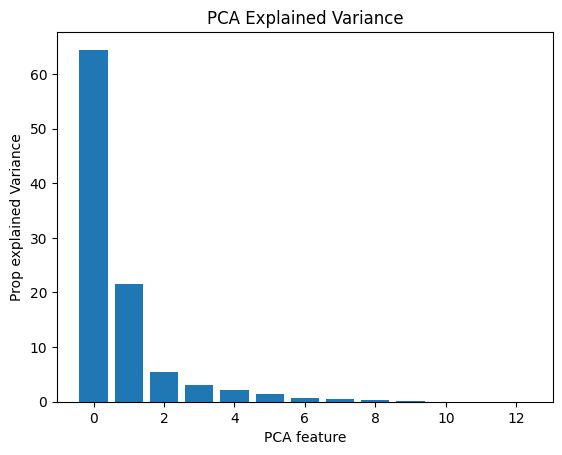

In [203]:
pca = PCA()

pca.fit(df_all[relevant_z_scores])
features = range(pca.n_components_)
fig, ax = plt.subplots()

ax.bar(features, pca.explained_variance_ratio_ * 100)
ax.set_xlabel("PCA feature")
ax.set_ylabel("Prop explained Variance")
ax.set_title("PCA Explained Variance")

In [204]:
pca_components = pca.fit_transform(df_all[relevant_z_scores])
fpc = pca_components[:, 0]

df_all.loc[:, 'PCA1'] = fpc

In [205]:
chosen_subset = df_all[df_all['chosen'] == 1]
rejected_subset = df_all[df_all['chosen'] == 0]

PCA_chosen_response_metric_pairs = pd.DataFrame({'response': chosen_subset.loc[:, 'response'], 'score': chosen_subset.loc[:, 'PCA1']}).reset_index(drop=True)
PCA_rejected_response_metric_pairs = pd.DataFrame({'response': rejected_subset.loc[:, 'response'], 'score': rejected_subset.loc[:, 'PCA1']}).reset_index(drop=True)

#Let's check out the stats on the metric real quick:
PCA_metric_distribution = pd.DataFrame({'Group': ['Accepted', 'Rejected'], 
                        'Mean' : [PCA_chosen_response_metric_pairs['score'].mean(), PCA_rejected_response_metric_pairs['score'].mean()], 
                        'Standard Deviaton': [np.std(PCA_chosen_response_metric_pairs['score']), np.std(PCA_rejected_response_metric_pairs['score'])],
                        'Variance': [np.var(PCA_chosen_response_metric_pairs['score']), np.var(PCA_rejected_response_metric_pairs['score'])],
                        'Max': [PCA_chosen_response_metric_pairs['score'].max(), PCA_rejected_response_metric_pairs['score'].max()],
                        'Min': [PCA_chosen_response_metric_pairs['score'].min(), PCA_rejected_response_metric_pairs['score'].min()]}) 

PCA_metric_distribution

,Group,Mean,Standard Deviaton,Variance,Max,Min
0,Accepted,0.494276,3.050283,9.304225,12.414935,-5.52919
1,Rejected,-0.494373,2.638178,6.959982,16.422423,-5.52919


In [206]:
df_pca['accepted_pca1'] = None
df_pca['rejected_pca1'] = None

for i in range(len(df_pca)):
    df_pca.iloc[i, df_pca.columns.get_loc('accepted_pca1')]= PCA_chosen_response_metric_pairs.iloc[np.where(PCA_chosen_response_metric_pairs['response'] == df_pca['chosen'][i])[0][0], -1]
    df_pca.iloc[i, df_pca.columns.get_loc('rejected_pca1')] = PCA_rejected_response_metric_pairs.iloc[np.where(PCA_rejected_response_metric_pairs['response'] == df_pca['rejected'][i])[0][0], -1]

df_pca['diff_pca1'] = df_pca['accepted_pca1'] - df_pca['rejected_pca1']

In [211]:
df_pca.to_csv("pca_metric_df.csv")

# Weighted PCA 

Might as well do a weighted Linear sum of all the features and their weights, although it really only takes 5 to get 96%

In [183]:
df_weighted_pca = df_clean.copy()

pca_weighted = PCA()

pca_weighted_comps = pca_weighted.fit_transform(df_all[relevant_z_scores])
pca_weighted_exp_var_rat = pca_weighted.explained_variance_ratio_



In [196]:
df_all.loc[:, 'weighted_pca'] = pca_weighted_comps @ pca_weighted_exp_var_rat

chosen_subset = df_all[df_all['chosen'] == 1]
rejected_subset = df_all[df_all['chosen'] == 0]

weighted_PCA_chosen_response_metric_pairs = pd.DataFrame({'response': chosen_subset.loc[:, 'response'], 'score': chosen_subset.loc[:, 'weighted_pca']}).reset_index(drop=True)
weighted_PCA_rejected_response_metric_pairs = pd.DataFrame({'response': rejected_subset.loc[:, 'response'], 'score': rejected_subset.loc[:, 'weighted_pca']}).reset_index(drop=True)

#Let's check out the stats on the metric real quick:
weighted_PCA_metric_distribution = pd.DataFrame({'Group': ['Accepted', 'Rejected'], 
                        'Mean' : [weighted_PCA_chosen_response_metric_pairs['score'].mean(), weighted_PCA_rejected_response_metric_pairs['score'].mean()], 
                        'Standard Deviaton': [np.std(weighted_PCA_chosen_response_metric_pairs['score']), np.std(weighted_PCA_rejected_response_metric_pairs['score'])],
                        'Variance': [np.var(weighted_PCA_chosen_response_metric_pairs['score']), np.var(weighted_PCA_rejected_response_metric_pairs['score'])],
                        'Max': [weighted_PCA_chosen_response_metric_pairs['score'].max(), weighted_PCA_rejected_response_metric_pairs['score'].max()],
                        'Min': [weighted_PCA_chosen_response_metric_pairs['score'].min(), weighted_PCA_rejected_response_metric_pairs['score'].min()]}) 

weighted_PCA_metric_distribution

,Group,Mean,Standard Deviaton,Variance,Max,Min
0,Accepted,0.30652,1.982479,3.930224,22.151480,-4.846351
1,Rejected,-0.30658,1.762129,3.105097,20.452313,-4.846351


In [199]:
df_weighted_pca['accepted_wpca'] = None
df_weighted_pca['rejected_wpca'] = None

for i in range(len(df_pca)):
    df_weighted_pca.iloc[i, df_weighted_pca.columns.get_loc('accepted_wpca')]= weighted_PCA_chosen_response_metric_pairs.iloc[np.where(weighted_PCA_chosen_response_metric_pairs['response'] == df_weighted_pca['chosen'][i])[0][0], -1]
    df_weighted_pca.iloc[i, df_weighted_pca.columns.get_loc('rejected_wpca')] = weighted_PCA_rejected_response_metric_pairs.iloc[np.where(weighted_PCA_rejected_response_metric_pairs['response'] == df_weighted_pca['rejected'][i])[0][0], -1]

df_weighted_pca['diff_wpca'] = df_weighted_pca['accepted_wpca'] - df_weighted_pca['rejected_wpca']

df_weighted_pca = df_weighted_pca.drop(columns=['accepted_linear_metric', 'rejected_linear_metric', 'diff_linear_metric'])


In [200]:
df_weighted_pca.to_csv('weighted_pca.csv')

# By Topic

### Which topics have the highest entropy/lowest entropy? n_polysylwords, etc.

In [ ]:
pd.DataFrame(df_all.groupby('topic_name')['n_uniquewords'].agg('mean')).sort_values(by='n_uniquewords', ascending=False)

,n_uniquewords
topic_name,
Healthy Lifestyle Exploration,161.350560
Environmental Impact Solutions,140.747352
Urban Exploration,138.836694
Marketing Strategy Platform,138.130298
Creative Writing,111.754293
Multi-dimensional Gaming,100.490716
Culinary Creations,99.736897
Childhood Stress and Health,91.819386
Cultural Expression,91.467339


### Which documents have the highest entropy/lowest entropy? n_polysylwords, etc.

In [ ]:
df_example = df_all.sort_values(by=['n_uniquewords', 'topic_name'], ascending=[False, False])
df_example = df_example.groupby('topic_name').head(1)
df_example = df_example[['topic_name', 'n_uniquewords', 'response']]
df_example

,topic_name,n_uniquewords,response
1730,Creative Writing,424.0,Title: Crescendo of the Heart\n\nChapter One -...
8349,Environmental Impact Solutions,404.0,Title: The Impact of Artificial Intelligence o...
20090,Healthy Lifestyle Exploration,392.0,Title: Electronic Voting Systems: A Glimpse in...
2936,Culinary Creations,377.0,"What purpose does frosting serve, and how does..."
3702,Cultural Expression,373.0,**In the acrid vapors of a renewed and retched...
17937,Urban Exploration,368.0,Hello! I'm here to help you format your Markdo...
2075,Marketing Strategy Platform,361.0,Title: On-the-Spot Business Plan\n\nExecutive ...
2946,Multi-dimensional Gaming,360.0,Of course! I'm glad to help you with that. Her...
18392,Gaming Economics,345.0,"Title: ""Fortnite Battle Royale Beginner's Guid..."
4580,Analyzing Product Sentiment,314.0,Title: The North Water\nTrailer Link: https://...
